In [162]:
from pdastro import pdastrostatsclass,AnotB
import re
import numpy as np
import re,os,sys,shutil
import tweakreg_hack
from jwst import datamodels
from astropy.table import Table
import astropy.io.fits as fits
import matplotlib.pyplot as plt


#d2d is calculated when gaia is matched to the objects, and is the distance 
# between the objects and their matched gaia positions. Give a rough upper limit on 
# what a good match should fall into
d2d_max = None
dmag_max = 0.05
Nbright=None
def calc_dxdy(phot,d2d_max=None,dmag_max=None,Nbright=None, ixs=None):
    ixs = phot.getindices(ixs)
    if d2d_max is not None:
        ixs = phot.ix_inrange('d2d',None,3*d2d_max,indices=ixs)
    if dmag_max is not None:
        ixs = phot.ix_inrange('dmag',None,dmag_max,indices=ixs)
    if Nbright is not None:
        ixs_sort = phot.ix_sort_by_cols(['mag'],indices=ixs)
        ixs = ixs_sort[:Nbright]
        phot.write(columns=['mag'],indices=ixs)
        
    print(f'# of matched objects that pass initial cuts: {len(ixs)}')
    phot.t.loc[ixs,'dx_idl'] = phot.t.loc[ixs,'cat_x_idl'] - phot.t.loc[ixs,'x_idl']
    phot.t.loc[ixs,'ddec'] = 3600.0*(phot.t.loc[ixs,'cat_dec'] - phot.t.loc[ixs,'dec'])
    phot.t.loc[ixs,'dra'] = 3600.0*(phot.t.loc[ixs,'cat_ra'] - phot.t.loc[ixs,'ra'])*np.cos(np.deg2rad(phot.t.loc[ixs,'dec']))
    phot.t.loc[ixs,'dx'] = phot.t.loc[ixs,'cat_x'] - phot.t.loc[ixs,'x']
    phot.t.loc[ixs,'dy'] = phot.t.loc[ixs,'cat_y'] - phot.t.loc[ixs,'y']
    return(ixs)

def infoplots(phot,ixs_good,ixs_bad,dy_plotlim=(-4,4),dx_plotlim=(-4,4)):
    sp=[]
    xfigsize=15.0
    yfigsize=10.0
    plt.figure(figsize=(xfigsize,yfigsize))
    sp.append(plt.subplot(231))
    sp.append(plt.subplot(232))
    sp.append(plt.subplot(233))
    sp.append(plt.subplot(234))
    sp.append(plt.subplot(235))

    phot.t.loc[ixs_bad].plot.scatter('x','dy',ax=sp[0],ylim=dy_plotlim,color='red')
    phot.t.loc[ixs_good].plot.scatter('x','dy',ax=sp[0],ylim=dy_plotlim,ylabel='dy in pixels')
    phot.t.loc[ixs_bad].plot.scatter('y','dx',ax=sp[1],ylim=dx_plotlim,color='red')
    phot.t.loc[ixs_good].plot.scatter('y','dx',ax=sp[1],ylim=dx_plotlim,ylabel='dx in pixels')

    phot.t.loc[ixs_bad].plot.scatter('x','y',ax=sp[2],color='red')
    phot.t.loc[ixs_good].plot.scatter('x','y',ax=sp[2])
    
    phot.t.loc[ixs_bad].plot.scatter('sharpness','mag',ax=sp[3],color='red')
    phot.t.loc[ixs_good].plot.scatter('sharpness','mag',ax=sp[3])

    phot.t.loc[ixs_bad].plot.scatter('sharpness','dmag',ax=sp[4],color='red')
    phot.t.loc[ixs_good].plot.scatter('sharpness','dmag',ax=sp[4])

    return(sp)


test/pid1069_testonly/jw01069001001_02101_00001_nrca1_cal.phot.txt
outdir: test/pid1069_testonly
NRCA1
filter:F070W
pupil: CLEAR
effective exptime: 96.631
# of matched objects that pass initial cuts: 1106
dx median: 0.015755500000068423, cut limits: (-2.9842444999999316, 3.0157555000000684)
dy median: 1.4741205000000264, cut limits: (-1.5258794999999736, 4.474120500000026)
good objects left: 297
median dmag of good object: 0.009728
median gaia_mag of good object: 18.93


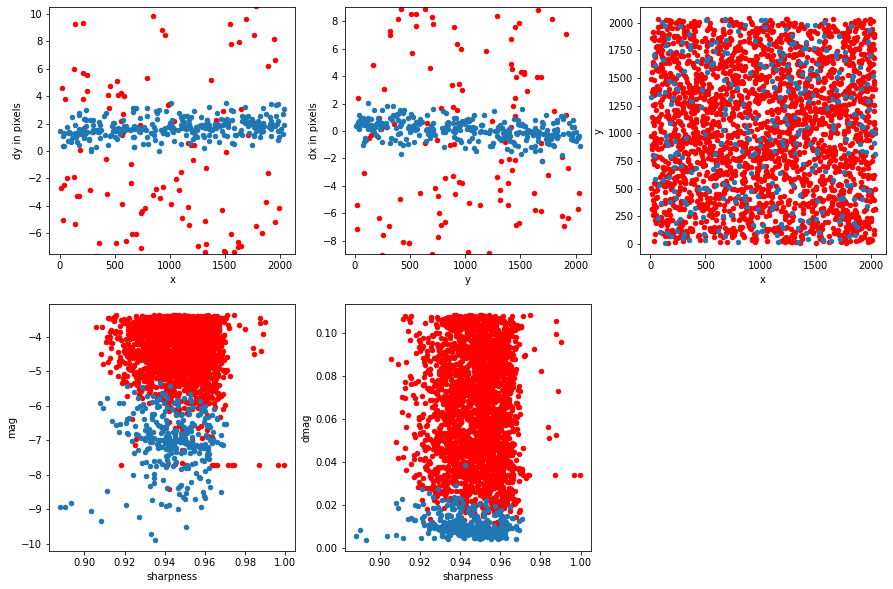

In [164]:
###
### 
cal_phot_filename = 'test/pid1069_testonly/jw01069001001_02101_00001_nrca1_cal.phot.txt' # 0.7 pixels stdev F070W
#cal_phot_filename = 'nrc24_calfiles/jw01073003001_02101_00001_nrca1_cal.phot.txt' # 0.08 pixels stdev F150W
#cal_phot_filename = 'coron_offsets/NRCA3_FULL_WEDGE_RND/jw01070001001_04101_00001_nrca3_cal.phot.txt' #  
#cal_phot_filename = '/ifs/jwst/wit/nircam/commissioning/01069/dist_applied/v1/jw01069002002_04101_00002_nrcblong_cal.phot.txt'
cal_image = re.sub('cal\.phot\.txt$','cal.fits',cal_phot_filename)
hdr = fits.getheader(cal_image)
#print(hdr)
outdir = os.path.dirname(cal_phot_filename)
print(f'{cal_phot_filename}\noutdir: {outdir}')
print(f'{hdr["DETECTOR"]}\nfilter:{hdr["FILTER"]}\npupil: {hdr["PUPIL"]}\neffective exptime: {hdr["EFFEXPTM"]}')

phot_cal = pdastrostatsclass()

phot_cal.load(cal_phot_filename)

ixs_cal = calc_dxdy(phot_cal,d2d_max=d2d_max,dmag_max=dmag_max,Nbright=Nbright)

cut_delta_pix = 3

dx_median = phot_cal.t.loc[ixs_cal,'dx'].median()
dy_median = phot_cal.t.loc[ixs_cal,'dy'].median()
# These are the limits for the cuts: remove all data points that are outside these limits
dxlim = (dx_median-cut_delta_pix,dx_median+cut_delta_pix)
dylim = (dy_median-cut_delta_pix,dy_median+cut_delta_pix)

print(f'dx median: {dx_median}, cut limits: {dxlim}')
print(f'dy median: {dy_median}, cut limits: {dylim}')

# these are the limits for the y-axis for the plots
dy_plotlim = (dy_median-3*cut_delta_pix,dy_median+3*cut_delta_pix)
dx_plotlim = (dx_median-3*cut_delta_pix,dx_median+3*cut_delta_pix)

# get the data points that are within the dx and dy limits
ixs_cal_good = phot_cal.ix_inrange('dx',dxlim[0],dxlim[1])
ixs_cal_good = phot_cal.ix_inrange('dy',dylim[0],dylim[1],indices=ixs_cal_good)
# get the bad data points
ixs_cal_bad = AnotB(phot_cal.getindices(),ixs_cal_good)

infoplots(phot_cal,ixs_cal_good,ixs_cal_bad,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)

#phot_cal.write(indices=ixs_cal_good)

print(f'good objects left: {len(ixs_cal_good)}')

# some extra info:
dmag_median = phot_cal.t.loc[ixs_cal_good,'dmag'].median()
gaia_mag_median = phot_cal.t.loc[ixs_cal_good,'gaia_mag'].median()
print(f'median dmag of good object: {dmag_median}')
print(f'median gaia_mag of good object: {gaia_mag_median}')


In [165]:
tweakreg = tweakreg_hack.TweakRegStep()
clobber = True
cal_image_dat = datamodels.open(cal_image)

tweakreg_image = f'{outdir}/'+re.sub('cal\.fits$','tweakregstep.fits',os.path.basename(cal_image))
print(f'{tweakreg_image}')
print(f'Setting output directory for tweakregstep.fits file to {outdir}')
tweakreg.output_dir = outdir
if not os.path.isdir(outdir):
    makepath(outdir)

if os.path.isfile(tweakreg_image):
    if clobber:
        os.remove(tweakreg_image)
    else:
        print('Not clobbering, so leaving.')
        sys.exit(1)
    
tweakreg.align_to_gaia = False
tweakreg.save_gaia_catalog = True
tweakreg.save_results = True
tweakreg.save_catalogs = True
tweakreg.snr_threshold = 50
tweakreg.separation = 9
tweakreg.searchrad = 0.5
tweakreg.minobj = 50
tweakreg.min_gaia = 30
# if you want to use x/yoffset, you need to set tweakreg.use2dhist=False
tweakreg.xoffset = 0
tweakreg.yoffset = 0
tweakreg.brightest = 200
tweakreg.fitgeometry = 'rshift'

tweakreg.already_matched = True
# phot_cal.t.loc[ixs_cal_good] is the table with the good matches!
t =  Table.from_pandas(phot_cal.t.loc[ixs_cal_good])
tweakreg.refcat = t
tweakreg.ref_racol = 'cat_ra'
tweakreg.ref_deccol = 'cat_dec'

### Provide your own source catalog, to be used in place of the default daofinder stuff. If you actually have a list
### of images, it's okay to provide a source catalog for each. 
cal_image_dat.source_catalog = t
cal_data = [cal_image_dat]
tweakreg.source_xcol = 'x'
tweakreg.source_ycol = 'y'

tweakreg.run(cal_data)

2022-05-22 10:34:31,909 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


test/pid1069_testonly/jw01069001001_02101_00001_nrca1_tweakregstep.fits
Setting output directory for tweakregstep.fits file to test/pid1069_testonly


2022-05-22 10:34:32,800 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01069001001_02101_00001_nrca1_cal.fits>],).
2022-05-22 10:34:32,802 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'test/pid1069_testonly', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 50, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 50, 'searchrad': 0.5, 'use2dhist': True, 'separation': 9, 'tolerance': 0.7, 'xoffset': 0, 'yoffset': 0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 30, 'save_gaia_catalog': True}
2022-05-22 10:34:32,820 - stpipe.Twea

<ModelContainer>

In [166]:
from simple_jwst_phot import jwst_photclass
tweakregphot=jwst_photclass()
tweakregphot.verbose = 2
gaia_catname_for_testing='./LMC_gaia_DR3.nrcposs'
align_gaia_SNR_min = 10.0
if not os.path.isfile(tweakreg_image):
    raise RuntimeError(f'BUG {tweakreg_image}')
tweakregphot.run_phot(tweakreg_image,gaia_catname_for_testing,SNR_min=align_gaia_SNR_min)
print('DONE!')


### Doing photometry on test/pid1069_testonly/jw01069001001_02101_00001_nrca1_tweakregstep.fits
Filename: test/pid1069_testonly/jw01069001001_02101_00001_nrca1_tweakregstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     351   ()      
  1  SCI           1 ImageHDU       112   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [117551038B]   
None
Instrument: NIRCAM, aperture:NRCA1_FULL
Applying Pixel Area Map
Converting units from MJy/sr to DN/s
Finding stars --- Detector: NRCA1, Fil

2022-05-22 10:34:42,347 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '

2022-05-22 10:34:43,237 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Background and rms using MMMBackground and MADStdBackgroundRMS: 0.08618953824043274 0.09573422446448222

Number of sources found in the image: 23570
-------------------------------------

radii:[1.974]pixels radius_sky_in:3.948 radius_sky_out:5.922  radius_for_mag:1.974
Performing aperture photometry for radius r = 1.974 px


2022-05-22 10:34:59,955 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:455: RuntimeWarning: invalid value encountered in sqrt
  error_poisson = np.sqrt(phot['aperture_sum'])

2022-05-22 10:34:59,958 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:467: RuntimeWarning: invalid value encountered in log10
  table_aper['mag'] = -2.5 * np.log10(table_aper[self.colname('aper_sum_bkgsub',rad)])



Time Elapsed: 13.790242396004032
2683 out of 23570 entries remain in photometry table
Matching Gaia catalog ./LMC_gaia_DR3.nrcposs
image objects are in x_idl=[-31.76,31.67] and y_idl=[-31.87,31.75] range
Keeping 321 out of 22544 catalog objects
Keeping 321  after removing NaNs from ra/dec
Saving test/pid1069_testonly/jw01069001001_02101_00001_nrca1_tweakregstep.phot.txt
DONE!


# of matched objects that pass initial cuts: 1106
dx median: -0.015482499999961874
dy median: -0.10229250000005408
good objects left: 209


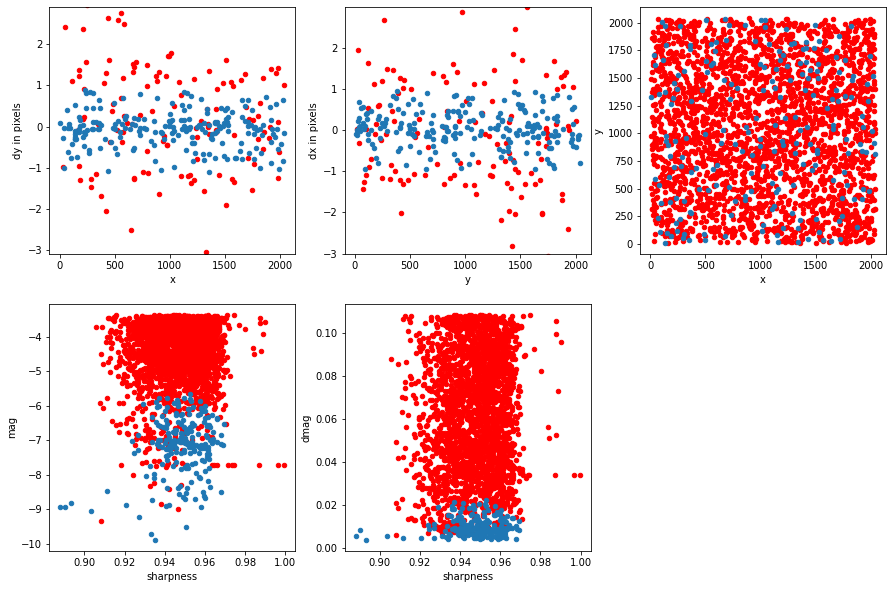

In [167]:
tweakreg_phot_filename = re.sub('fits$','phot.txt',tweakreg_image)
if tweakreg_phot_filename==tweakreg_image:
    raise RuntimeError(f'BUG!! {tweakreg_image}')

phot_tweakreg = pdastrostatsclass()

phot_tweakreg.load(tweakreg_phot_filename)

ixs_tweakreg = calc_dxdy(phot_tweakreg,d2d_max,dmag_max)

cut_delta_pix = 1

dx_median = phot_tweakreg.t.loc[ixs_tweakreg,'dx'].median()
dy_median = phot_tweakreg.t.loc[ixs_tweakreg,'dy'].median()
print(f'dx median: {dx_median}')
print(f'dy median: {dy_median}')
dy_plotlim = (dy_median-3*cut_delta_pix,dy_median+3*cut_delta_pix)
dx_plotlim = (dx_median-3*cut_delta_pix,dx_median+3*cut_delta_pix)

dxlim = (dx_median-cut_delta_pix,dx_median+cut_delta_pix)
dylim = (dy_median-cut_delta_pix,dy_median+cut_delta_pix)
ixs_tweakreg_good = phot_tweakreg.ix_inrange('dx',dxlim[0],dxlim[1])
ixs_tweakreg_good = phot_tweakreg.ix_inrange('dy',dylim[0],dylim[1],indices=ixs_tweakreg_good)
ixs_tweakreg_bad = AnotB(phot_tweakreg.getindices(),ixs_tweakreg_good)

infoplots(phot_tweakreg,ixs_tweakreg_good,ixs_tweakreg_bad,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)

print(f'good objects left: {len(ixs_tweakreg_good)}')



In [168]:
print('\n####################\n### dx')
#ixs_clean4average = phot_clear.ix_inrange('dx',0,3,indices=ixs_clear_cut)
phot_tweakreg.calcaverage_sigmacutloop('dx',verbose=3,indices=ixs_tweakreg_good,percentile_cut_firstiteration=85)
print(phot_tweakreg.statstring())
print('\n####################\n### dy')
phot_tweakreg.calcaverage_sigmacutloop('dy',verbose=3,indices=ixs_tweakreg_good,percentile_cut_firstiteration=85)
print(phot_tweakreg.statstring())
#phot_gaia.t['test_ddec'] = 3600.0*(phot_gaia.t['dec']-phot.t['dec'])
#phot_gaia.t.plot.scatter('dec','test_ddec')
#print(phot_gaia.t['test_ddec'])



####################
### dx
Keeping 209 out of 209, skippin 0 because of null values in columns dx
median: 0.042461
85.000000 percentile cut: max residual for cut: 0.715536
median: 0.042461
i:00 mean:0.042461(0.024483) stdev:0.324810(0.017263) X2norm:1.00 Nchanged:0 Ngood:177 Nclip:32

mean: 0.057265
i:01 mean:0.057265(0.030049) stdev:0.430233(0.021196) X2norm:1.00 Nchanged:29 Ngood:206 Nclip:3

mean: 0.042925
i:02 mean:0.042925(0.030745) stdev:0.443417(0.021688) X2norm:1.00 Nchanged:3 Ngood:209 Nclip:0

mean: 0.042925
i:03 mean:0.042925(0.030745) stdev:0.443417(0.021688) X2norm:1.00 Nchanged:0 Ngood:209 Nclip:0
i:03 mean:0.042925(0.030745) stdev:0.443417(0.021688) X2norm:1.00 Nchanged:0 Ngood:209 Nclip:0

####################
### dy
Keeping 209 out of 209, skippin 0 because of null values in columns dy
median: -0.047216
85.000000 percentile cut: max residual for cut: 0.687682
median: -0.040983
i:00 mean:-0.040983(0.023346) stdev:0.309721(0.016462) X2norm:1.00 Nchanged:0 Ngood:177 Ncl

<AxesSubplot:xlabel='x', ylabel='y'>

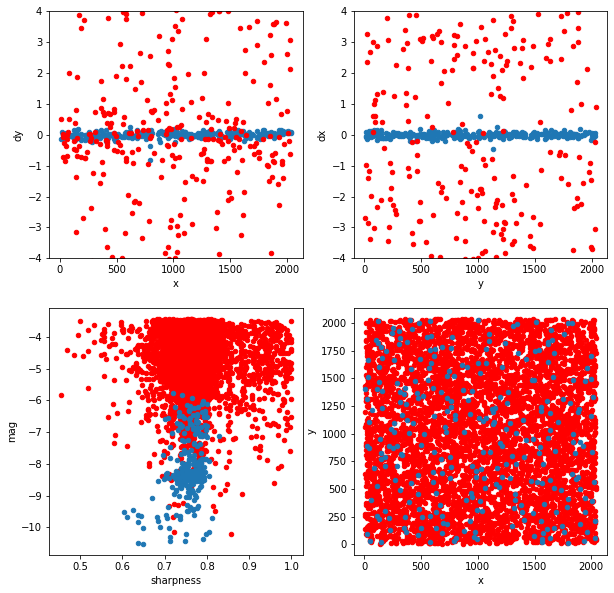

In [132]:
import matplotlib.pyplot as plt
sp=[]
xfigsize=yfigsize=10.0
plt.figure(figsize=(xfigsize,yfigsize))
sp.append(plt.subplot(221))
sp.append(plt.subplot(222))
sp.append(plt.subplot(223))
sp.append(plt.subplot(224))

dy_plotlim = dx_plotlim = (-4,4)

phot_tweakreg.t.loc[ixs_tweakreg_good].plot.scatter('x','dy',ax=sp[0],ylim=dy_plotlim,ylabel='dy in pixels')
phot_tweakreg.t.loc[ixs_tweakreg_bad].plot.scatter('x','dy',ax=sp[0],ylim=dy_plotlim,color='red')
phot_tweakreg.t.loc[ixs_tweakreg_good].plot.scatter('y','dx',ax=sp[1],ylim=dx_plotlim,ylabel='dx in pixels')
phot_tweakreg.t.loc[ixs_tweakreg_bad].plot.scatter('y','dx',ax=sp[1],ylim=dx_plotlim,color='red')

phot_tweakreg.t.loc[ixs_tweakreg_bad].plot.scatter('sharpness','mag',ax=sp[2],color='red')
phot_tweakreg.t.loc[ixs_tweakreg_good].plot.scatter('sharpness','mag',ax=sp[2])

phot_tweakreg.t.loc[ixs_tweakreg_bad].plot.scatter('x','y',ax=sp[3],color='red')
phot_tweakreg.t.loc[ixs_tweakreg_good].plot.scatter('x','y',ax=sp[3])
